In this notebook, three embedding generation methods (PCA, non-negative ALS, autoencoder) were tested to generate user profiles from a MovieLens 20M dataset of lower dimensionality. Recall that the original profile dimensionality is 320. In addition, the applicability of the embedding generation methods was investigated in terms of the quality of the synthetic data generation models and in terms of the quality of the response function component responsible for approximating the response from historical data.

In [2]:
import os

import pandas as pd
import numpy as np
import time
import matplotlib
import itertools

from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
import pyspark.sql.types as st
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, FMClassifier
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.functions import vector_to_array
from pyspark.ml import Pipeline 
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

from replay.session_handler import State

from sim4rec.utils import pandas_to_spark
from sim4rec.response import ParametricResponseFunction, BernoulliResponse
from sim4rec.utils import VectorElementExtractor
from sim4rec.modules import RealDataGenerator, SDVDataGenerator
from sim4rec.modules import evaluate_synthetic
from sim4rec.modules import EncoderEstimator

from sklearn.metrics import roc_auc_score, precision_score, recall_score

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

spark = SparkSession.builder\
    .appName('simulator_movielens')\
    .master('local[8]')\
    .config('spark.sql.shuffle.partitions', '8')\
    .config('spark.default.parallelism', '8')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '128g')\
    .config('spark.local.dir', './tmp')\
    .getOrCreate()

State(spark)

22/10/18 09:46:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/18 09:46:06 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/10/18 09:46:08 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/18 09:46:08 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/10/18 09:46:08 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/10/18 09:46:08 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
22/10/18 09:46:08 WARN Utils: Service 'SparkUI' could 

# Read data

We work with preprocessed data, which are split into three parts by timestamp. Ratings 1 and 2 are considered negative (0); 3, 4 and 5 are positive (1).

The data have been preprocessed (code in Movielens folder): user profiles and response history recomendations have been generated, and the data have been split into train, validation and test samples by timestamp.

In [3]:
DATA_PATH = r'file:///data/home/estavinova/simulator/data/Movielens/'

In [4]:
USER_PREFIX = 'user_'
ITEM_PREFIX = 'item_'

USER_SCHEMA = st.StructType(
    [st.StructField('user_idx', st.IntegerType())] +\
    [st.StructField(f'genre{i}', st.DoubleType()) for i in range(19)] +\
    [st.StructField('rating_avg', st.DoubleType())] +\
    [st.StructField(f'w2v_{i}', st.DoubleType()) for i in range(300)]
)
ITEM_SCHEMA = st.StructType(
    [st.StructField('item_idx', st.IntegerType())] +\
    [st.StructField('year', st.IntegerType())] +\
    [st.StructField('rating_avg', st.DoubleType())] +\
    [st.StructField(f'genre{i}', st.DoubleType()) for i in range(19)] +\
    [st.StructField(f'w2v_{i}', st.DoubleType()) for i in range(300)]
)
LOG_SCHEMA = st.StructType([
    st.StructField('user_idx', st.IntegerType()),
    st.StructField('item_idx', st.IntegerType()),
    st.StructField('relevance', st.DoubleType()),
    st.StructField('timestamp', st.IntegerType())
])

users_df_train = spark.read.csv(DATA_PATH+'train/users.csv', header=True, schema=USER_SCHEMA)
items_df_train = spark.read.csv(DATA_PATH+'train/items.csv', header=True, schema=ITEM_SCHEMA)
log_df_train   = spark.read.csv(DATA_PATH+'train/rating.csv', header=True, schema=LOG_SCHEMA)

log_df_train = log_df_train.join(users_df_train, log_df_train['user_idx'] == users_df_train['user_idx'], 'leftsemi')
log_df_train = log_df_train.join(items_df_train, log_df_train['item_idx'] == items_df_train['item_idx'], 'leftsemi')

for c in users_df_train.columns[1:]:
    users_df_train = users_df_train.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_train.columns[1:]:
    items_df_train = items_df_train.withColumnRenamed(c, 'item_' + c)

log_df_train = log_df_train.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

users_df_train = users_df_train.cache()
items_df_train = items_df_train.cache()
log_df_train = log_df_train.cache()

users_df_train.count()
items_df_train.count()
log_df_train.count()

22/10/18 11:02:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


10000132

In [5]:
users_df_val = spark.read.csv(DATA_PATH+'val/users.csv', header=True, schema=USER_SCHEMA)
items_df_val = spark.read.csv(DATA_PATH+'val/items.csv', header=True, schema=ITEM_SCHEMA)
log_df_val   = spark.read.csv(DATA_PATH+'val/rating.csv', header=True, schema=LOG_SCHEMA)

log_df_val = log_df_val.join(users_df_val, log_df_val['user_idx'] == users_df_val['user_idx'], 'leftsemi')
log_df_val = log_df_val.join(items_df_val, log_df_val['item_idx'] == items_df_val['item_idx'], 'leftsemi')

for c in users_df_val.columns[1:]:
    users_df_val = users_df_val.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_val.columns[1:]:
    items_df_val = items_df_val.withColumnRenamed(c, 'item_' + c)

log_df_val = log_df_val.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

users_df_val = users_df_val.cache()
items_df_val = items_df_val.cache()
log_df_val = log_df_val.cache()

users_df_val.count()
items_df_val.count()
log_df_val.count()

5000065

In [6]:
users_df_test = spark.read.csv(DATA_PATH+'test/users.csv', header=True, schema=USER_SCHEMA)
items_df_test = spark.read.csv(DATA_PATH+'test/items.csv', header=True, schema=ITEM_SCHEMA)
log_df_test   = spark.read.csv(DATA_PATH+'test/rating.csv', header=True, schema=LOG_SCHEMA)

log_df_test = log_df_test.join(users_df_test, log_df_test['user_idx'] == users_df_test['user_idx'], 'leftsemi')
log_df_test = log_df_test.join(items_df_test, log_df_test['item_idx'] == items_df_test['item_idx'], 'leftsemi')

for c in users_df_test.columns[1:]:
    users_df_test = users_df_test.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_test.columns[1:]:
    items_df_test = items_df_test.withColumnRenamed(c, 'item_' + c)

log_df_test = log_df_test.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

items_df_test = items_df_test.na.drop()

users_df_test = users_df_test.cache()
items_df_test = items_df_test.cache()
log_df_test = log_df_test.cache()

users_df_test.count()
items_df_test.count()
log_df_test.count()

5000066

# Initial quality of response function Real component

First, we evaluate the quality of the Real component, responsible for approximating the response in historical data, on the original user and offer profiles.

Recall that the profiles of users and items related to the train period (users_df_train and items_df_train, respectively) are generated from the interaction history from log_df_train. Therefore, the user profiles users_df_train and item profiles items_df_train and the log log_df_val are used to train the response model. The users_df_val and items_df_val profiles constructed from the combined log of log_df_train and log_df_val, as well as the log_df_test log, are used to evaluate the quality of the response model.

Translated with DeepL.com (free version)

# Logistic regression

In [56]:
va = VectorAssembler(
    inputCols=users_df_train.columns[1:] + items_df_train.columns[2:],
    outputCol='features'
)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__lr_prob'
)

train_df = log_df_val.join(users_df_train, 'user_idx', 'left')\
                     .join(items_df_train, 'item_idx', 'left')\
                     .drop('timestamp')
train_df = train_df.na.drop()

start = time.time()
lr_model = lr.fit(va.transform(train_df))
end = time.time()
print("Fitting of logistic regression: ")
print(end - start)

Fitting of logistic regression: 
132.58816146850586


In [58]:
vee = VectorElementExtractor(inputCol='__lr_prob', outputCol='__r1', index=1)
br = BernoulliResponse (inputCol='__r1', outputCol='response', seed=1234)
pipeline = Pipeline(
    stages=[
        va,
        lr_model,
        vee,
        br
    ]
)

In [63]:
test_df = log_df_test.join(users_df_val, 'user_idx', 'left')\
                     .join(items_df_val, 'item_idx', 'left')\
                     .drop('timestamp')
test_df = test_df.na.drop()

In [65]:
start = time.time()
ber_lr_model = pipeline.fit(train_df)
end = time.time()
print("Pipeline fitting: ")
print(end - start)
pred_df = ber_lr_model.transform(test_df).select("user_idx", "item_idx", "relevance", "__r1").toPandas()

Pipeline fitting: 
0.00027823448181152344


In [66]:
print(f"Regression ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")

Regression ROC AUC: 0.7297195129242636


# Random forest

In [67]:
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__rf_prob'
)

start = time.time()
rf_model = rf.fit(va.transform(train_df))
end = time.time()
print("Fitting of random forest: ")
print(end - start)

Fitting of random forest: 
113.6255989074707


In [68]:
vee = VectorElementExtractor(inputCol='__rf_prob', outputCol='__r1', index=1)
br = BernoulliResponse(inputCol='__r1', outputCol='response', seed=1234)
pipeline = Pipeline(
    stages=[
        va,
        rf_model,
        vee,
        br
    ]
)

In [69]:
start = time.time()
ber_rf_model = pipeline.fit(train_df)
end = time.time()
print("Pipeline fitting: ")
print(end - start)
pred_df = ber_rf_model.transform(test_df).select("user_idx", "item_idx", "relevance", "__r1").toPandas()

Pipeline fitting: 
0.0010902881622314453


In [70]:
print(f"Random forest ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")

Random forest ROC AUC: 0.6617090871766477


# Factorization machines

In [72]:
fm = FMClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__fm_prob'
)

start = time.time()
fm_model = fm.fit(va.transform(train_df))
end = time.time()
print("Fitting of factorization machines: ")
print(end - start)

Fitting of factorization machines: 
5645.503440380096


In [73]:
vee = VectorElementExtractor(inputCol='__fm_prob', outputCol='__r1', index=1)
br = BernoulliResponse(inputCol='__r1', outputCol='response', seed=1234)
pipeline = Pipeline(
    stages=[
        va,
        fm_model,
        vee,
        br
    ]
)

In [75]:
start = time.time()
ber_fm_model = pipeline.fit(train_df)
end = time.time()
print("Pipeline fitting: ")
print(end - start)
pred_df = ber_fm_model.transform(test_df).select("user_idx", "item_idx", "relevance", "__r1").toPandas()

Pipeline fitting: 
0.0002014636993408203


In [76]:
print(f"Factorization machines ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")

Factorization machines ROC AUC: 0.6810336369328058


# PCA

Let's generate embeddings of user profiles. The number of components was chosen to be 9, because starting from the 10th value the increase in the share of explained variance is less than 0.01.

In [49]:
va = VectorAssembler(
    inputCols=users_df_train.columns[1:],
    outputCol='features'
)
pca = PCA(k=9, inputCol="features")
pca.setOutputCol("pca_features")
start = time.time()
model = pca.fit(va.transform(users_df_train))
end = time.time()
print("PCA fitting: ")
print(end - start)
model.explainedVariance

PCA fitting: 
3.358234405517578


DenseVector([0.5139, 0.1649, 0.0891, 0.0435, 0.0366, 0.0279, 0.0189, 0.0136, 0.0108])

In [50]:
pca_users = model.transform(va.transform(users_df_train)).select(['user_idx', 'pca_features'])

pca_users = (pca_users.withColumn('user_feature', vector_to_array('pca_features'))).select(['user_idx'] + [col('user_feature')[i] for i in range(9)])
pca_users.toPandas()

,user_idx,user_feature[0],user_feature[1],user_feature[2],user_feature[3],user_feature[4],user_feature[5],user_feature[6],user_feature[7],user_feature[8]
0,1,-3.622775,-0.577107,-0.162202,-0.176447,-0.253122,-0.116941,0.235773,0.264329,0.292615
1,2,-3.961731,-0.617859,-0.131752,-0.185460,-0.139910,0.105091,0.191646,0.156198,0.059740
2,3,-4.084716,-0.625386,-0.236358,-0.193491,-0.118895,0.153699,0.044418,0.267825,-0.053132
3,4,-3.525531,-0.609608,-0.221708,-0.589832,0.169298,0.038561,-0.000828,0.195264,-0.038426
4,5,-4.251370,-0.383833,-0.341450,-0.353603,0.228462,0.070112,0.037554,0.239054,0.008435
...,...,...,...,...,...,...,...,...,...,...
80645,138483,-3.147429,-0.098111,-0.024827,-0.378338,0.148554,0.112192,0.027015,0.193308,-0.003480
80646,138484,-3.287778,-0.394522,-0.021202,-0.499686,0.129370,0.085624,0.015235,0.210864,0.017104
80647,138487,-4.226937,0.019180,-0.178634,-0.431476,0.097237,0.117792,0.046617,0.185198,0.009766
80648,138488,-2.773391,-0.226021,-0.468202,-0.335409,0.403278,-0.101171,0.170729,0.348078,0.041154


In [80]:
pca_users_val = model.transform(va.transform(users_df_val)).select(['user_idx', 'pca_features'])

pca_users_val = (pca_users_val.withColumn('user_feature', vector_to_array('pca_features'))).select(['user_idx'] + [col('user_feature')[i] for i in range(9)])
pca_users_val.toPandas()


[Stage 4252:>                                                       (0 + 8) / 8]



,user_idx,user_feature[0],user_feature[1],user_feature[2],user_feature[3],user_feature[4],user_feature[5],user_feature[6],user_feature[7],user_feature[8]
0,1,-3.703400,-0.645062,-0.321042,-0.159401,0.019337,-0.036376,0.057187,0.215621,0.185469
1,2,-3.961731,-0.617859,-0.131752,-0.185460,-0.139910,0.105091,0.191646,0.156198,0.059740
2,3,-4.084716,-0.625386,-0.236358,-0.193491,-0.118895,0.153699,0.044418,0.267825,-0.053132
3,4,-3.525531,-0.609608,-0.221708,-0.589832,0.169298,0.038561,-0.000828,0.195264,-0.038426
4,5,-4.251370,-0.383833,-0.341450,-0.353603,0.228462,0.070112,0.037554,0.239054,0.008435
...,...,...,...,...,...,...,...,...,...,...
106568,138486,-3.754245,-0.594776,-0.276480,-0.323980,-0.118774,-0.139955,0.160285,0.273831,0.185347
106569,138487,-4.226937,0.019180,-0.178634,-0.431476,0.097237,0.117792,0.046617,0.185198,0.009766
106570,138488,-2.773391,-0.226021,-0.468202,-0.335409,0.403278,-0.101171,0.170729,0.348078,0.041154
106571,138490,-3.587840,0.159587,0.228046,-0.235890,0.178379,0.121799,-0.032171,0.095645,-0.086517


# Generators quality with PCA

# GaussianCopula

In [7]:
user_generator_1 = SDVDataGenerator(
    label='synth',
    id_column_name='user_idx',
    model_name='gaussiancopula',
    parallelization_level=4,
    seed=1234
)

start = time.time()
user_generator_1.fit(pca_users.drop('user_idx'))
end = time.time()
print('Fitting of GaussianCopula on PCA embeddings: ')
print(end - start)


[Stage 18:=====================>                                    (3 + 5) / 8]



Fitting of GaussianCopula on PCA embeddings: 
37.62059164047241


In [8]:
real_users = pca_users.sample(0.12)
syn_users = user_generator_1.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_idx'),
    real_users.drop('user_idx')
)

In [9]:
gen_score

{'LogisticDetection': 0.9609056686313161,
 'SVCDetection': 0.3050308615535612,
 'KSTest': 0.957127399054616,
 'ContinuousKLDivergence': 0.9423131904276859}

In [10]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'GaussianCopula'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_pca = pd.DataFrame()
gen_result_df_pca = pd.concat([gen_result_df_pca, gen_result])
gen_result_df_pca

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.960906,LogisticDetection
1,GaussianCopula,0.305031,SVCDetection
2,GaussianCopula,0.957127,KSTest
3,GaussianCopula,0.942313,ContinuousKLDivergence


# CTGAN

In [11]:
user_generator_2 = SDVDataGenerator(
    label='synth',
    id_column_name='user_idx',
    model_name='ctgan',
    parallelization_level=4,
    seed=1234
)

start = time.time()
user_generator_2.fit(pca_users.drop('user_idx'))
end = time.time()
print('Fitting of CTGAN on PCA embeddings: ')
print(end - start)


[Stage 25:>                                                         (0 + 8) / 8]



Fitting of CTGAN on PCA embeddings: 
2659.908476114273


In [14]:
real_users = pca_users.sample(0.12)
syn_users = user_generator_2.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_idx'),
    real_users.drop('user_idx')
)

In [15]:
gen_score

{'LogisticDetection': 0.5862689619912471,
 'SVCDetection': 0.2214573368183812,
 'KSTest': 0.887943709304768,
 'ContinuousKLDivergence': 0.8518635181200033}

In [16]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'CTGAN'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_pca = pd.concat([gen_result_df_pca, gen_result])
gen_result_df_pca

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.960906,LogisticDetection
1,GaussianCopula,0.305031,SVCDetection
2,GaussianCopula,0.957127,KSTest
3,GaussianCopula,0.942313,ContinuousKLDivergence
0,CTGAN,0.586269,LogisticDetection
1,CTGAN,0.221457,SVCDetection
2,CTGAN,0.887944,KSTest
3,CTGAN,0.851864,ContinuousKLDivergence


# CopulaGAN

In [17]:
user_generator_3 = SDVDataGenerator(
    label='synth',
    id_column_name='user_idx',
    model_name='copulagan',
    parallelization_level=4,
    seed=1234
)

start = time.time()
user_generator_3.fit(pca_users.drop('user_idx'))
end = time.time()
print('Fitting of CopulaGAN on PCA embeddings: ')
print(end - start)

Fitting of CopulaGAN on PCA embeddings: 
2606.1062290668488


In [18]:
real_users = pca_users.sample(0.12)
syn_users = user_generator_3.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_idx'),
    real_users.drop('user_idx')
)

In [19]:
gen_score

{'LogisticDetection': 0.5308309839353935,
 'SVCDetection': 0.14414392453056024,
 'KSTest': 0.8801101029666634,
 'ContinuousKLDivergence': 0.7730488485630536}

In [20]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'CopulaGAN'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_pca = pd.concat([gen_result_df_pca, gen_result])
gen_result_df_pca

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.960906,LogisticDetection
1,GaussianCopula,0.305031,SVCDetection
2,GaussianCopula,0.957127,KSTest
3,GaussianCopula,0.942313,ContinuousKLDivergence
0,CTGAN,0.586269,LogisticDetection
1,CTGAN,0.221457,SVCDetection
2,CTGAN,0.887944,KSTest
3,CTGAN,0.851864,ContinuousKLDivergence
0,CopulaGAN,0.530831,LogisticDetection
1,CopulaGAN,0.144144,SVCDetection


# TVAE

In [21]:
user_generator_4 = SDVDataGenerator(
    label='synth',
    id_column_name='user_idx',
    model_name='tvae',
    parallelization_level=4,
    seed=1234
)

start = time.time()
user_generator_4.fit(pca_users.drop('user_idx'))
end = time.time()
print('Fitting of TVAE on PCA embeddings: ')
print(end - start)

Fitting of TVAE on PCA embeddings: 
895.7267322540283


In [24]:
real_users = pca_users.sample(0.12)
syn_users = user_generator_4.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_idx'),
    real_users.drop('user_idx')
)

In [25]:
gen_score

{'LogisticDetection': 0.6081826589356636,
 'SVCDetection': 0.054738535666314814,
 'KSTest': 0.7878272145230569,
 'ContinuousKLDivergence': 0.7260824735860538}

In [26]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'TVAE'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_pca = pd.concat([gen_result_df_pca, gen_result])
gen_result_df_pca

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.960906,LogisticDetection
1,GaussianCopula,0.305031,SVCDetection
2,GaussianCopula,0.957127,KSTest
3,GaussianCopula,0.942313,ContinuousKLDivergence
0,CTGAN,0.586269,LogisticDetection
1,CTGAN,0.221457,SVCDetection
2,CTGAN,0.887944,KSTest
3,CTGAN,0.851864,ContinuousKLDivergence
0,CopulaGAN,0.530831,LogisticDetection
1,CopulaGAN,0.144144,SVCDetection


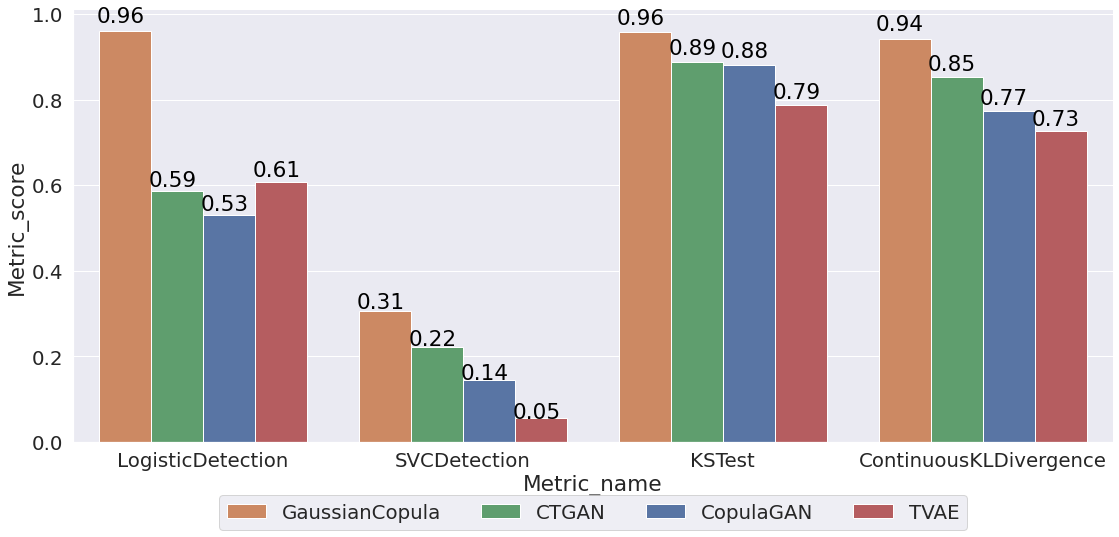

In [31]:
def create_hist_values(df):
    model_names = df['Model_name'].unique()
    metric_names = df["Metric_name"].unique()
    hist_values = []
    for model, metric in itertools.product(model_names, metric_names):
        hist_values.append(df[(df['Model_name'] == model) & (df['Metric_name'] == metric)]['Metric_score'].values[0])
    return hist_values

rcParams['figure.figsize'] = (3, 3)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.set(font_scale=1.8) 
plot = sns.catplot(data=gen_result_df_pca, x="Metric_name", y="Metric_score", hue="Model_name", kind="bar", aspect=2, height=8, palette=[
    "C1", "C2", "C0", "C3", "C4"
], legend=False)
ax = plot.facet_axis(0,0)
hist_val = create_hist_values(gen_result_df_pca)
for (p, val) in zip(ax.patches, hist_val):
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{:1.2f}'.format(val),   
            color='black', 
            rotation='horizontal', 
            size='medium')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=5)
plt.tight_layout()

It can be seen that GaussianCopula gives quite decent quality for all metrics. Moreover, the training is quick.

# Response function Real component quality

Let us verify that the use of embeddings does not degrade the quality of the Real component of the response function.

# Logistic Regression

In [77]:
va = VectorAssembler(
    inputCols=pca_users.columns[1:] + items_df_train.columns[2:],
    outputCol='features'
)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__lr_prob'
)

train_df = log_df_val.join(pca_users, 'user_idx', 'left')\
                     .join(items_df_train, 'item_idx', 'left')\
                     .drop('timestamp')
train_df = train_df.na.drop()

start = time.time()
lr_model = lr.fit(va.transform(train_df))
end = time.time()
print("Fitting of logistic regression: ")
print(end - start)

Fitting of logistic regression: 
58.82204461097717


In [84]:
vee = VectorElementExtractor(inputCol='__lr_prob', outputCol='__r1', index=1)
br = BernoulliResponse (inputCol='__r1', outputCol='response', seed=1234)
pipeline = Pipeline(
    stages=[
        va,
        lr_model,
        vee,
        br
    ]
)

In [82]:
test_df = log_df_test.join(pca_users_val, 'user_idx', 'left')\
                     .join(items_df_val, 'item_idx', 'left')\
                     .drop('timestamp')
test_df = test_df.na.drop()

In [85]:
start = time.time()
ber_lr_model = pipeline.fit(train_df)
end = time.time()
print("Pipeline fitting: ")
print(end - start)
pred_df = ber_lr_model.transform(test_df).select("user_idx", "item_idx", "relevance", "__r1").toPandas()

Pipeline fitting: 
0.00019621849060058594


In [86]:
print(f"Regression ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")

Regression ROC AUC: 0.7344131027798593


# Random forest

In [87]:
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__rf_prob'
)

start = time.time()
rf_model = rf.fit(va.transform(train_df))
end = time.time()
print("Fitting of random forest: ")
print(end - start)

Fitting of random forest: 
49.03646993637085


In [88]:
vee = VectorElementExtractor(inputCol='__rf_prob', outputCol='__r1', index=1)
br = BernoulliResponse(inputCol='__r1', outputCol='response', seed=1234)
pipeline = Pipeline(
    stages=[
        va,
        rf_model,
        vee,
        br
    ]
)

In [89]:
start = time.time()
ber_rf_model = pipeline.fit(train_df)
end = time.time()
print("Pipeline fitting: ")
print(end - start)
pred_df = ber_rf_model.transform(test_df).select("user_idx", "item_idx", "relevance", "__r1").toPandas()

Pipeline fitting: 
0.0013325214385986328


In [90]:
print(f"Random forest ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")

Random forest ROC AUC: 0.7060553470795717


# Factorization machines

In [91]:
fm = FMClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__fm_prob'
)

start = time.time()
fm_model = fm.fit(va.transform(train_df))
end = time.time()
print("Fitting of factorization machines: ")
print(end - start)

Fitting of factorization machines: 
1590.3620653152466


In [92]:
vee = VectorElementExtractor(inputCol='__fm_prob', outputCol='__r1', index=1)
br = BernoulliResponse(inputCol='__r1', outputCol='response', seed=1234)
pipeline = Pipeline(
    stages=[
        va,
        fm_model,
        vee,
        br
    ]
)

In [93]:
start = time.time()
ber_fm_model = pipeline.fit(train_df)
end = time.time()
print("Pipeline fitting: ")
print(end - start)
pred_df = ber_fm_model.transform(test_df).select("user_idx", "item_idx", "relevance", "__r1").toPandas()

Pipeline fitting: 
0.00039696693420410156


In [94]:
print(f"Factorization machines ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")

Factorization machines ROC AUC: 0.6982117910356826


It appeared that the quality of the Real component was higher when using PCA embeddings than when using the original attributes.

# Non-negative ALS

Let's do the same experiments with another method of generating embeddings.

In [95]:
log_df_train = log_df_train.withColumnRenamed('user_idx', 'user')
log_df_train = log_df_train.withColumnRenamed('item_idx', 'item')
log_df_train = log_df_train.withColumnRenamed('relevance', 'rating')

In [96]:
als = ALS(rank=15, maxIter=10, seed=0, nonnegative = True)
start = time.time()
model = als.fit(log_df_train.select(["user", "item", "rating"]))
end = time.time()
print("Fitting of ALS: ")
print(end - start)

Fitting of ALS: 
21.011656522750854


In [97]:
user_features = model.userFactors.orderBy("id")
user_features = (user_features.withColumn('user_feature', col('features'))).select(['id'] + [col('user_feature')[i] for i in range(15)])
user_features.toPandas()

,id,user_feature[0],user_feature[1],user_feature[2],user_feature[3],user_feature[4],user_feature[5],user_feature[6],user_feature[7],user_feature[8],user_feature[9],user_feature[10],user_feature[11],user_feature[12],user_feature[13],user_feature[14]
0,1,0.366036,0.167967,0.310271,0.163908,0.245759,0.115145,0.192681,0.318888,0.295416,0.109105,0.413338,0.215165,0.154725,0.252735,0.156242
1,2,0.346396,0.153690,0.320338,0.151222,0.227186,0.112479,0.201141,0.299084,0.275671,0.119904,0.394898,0.212090,0.161613,0.238222,0.151326
2,3,0.343621,0.145792,0.372653,0.144291,0.217801,0.119706,0.237619,0.298569,0.271030,0.152626,0.401229,0.232599,0.194233,0.240645,0.162552
3,4,0.305827,0.104898,0.462517,0.111623,0.168905,0.121152,0.313653,0.249925,0.230524,0.227674,0.373914,0.246961,0.250386,0.206972,0.160188
4,5,0.331969,0.140618,0.345012,0.140473,0.210842,0.111977,0.222971,0.282670,0.262012,0.142079,0.383227,0.215257,0.177955,0.226737,0.150010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80645,138483,0.341975,0.164484,0.238430,0.159197,0.237523,0.100451,0.143573,0.298648,0.279270,0.069936,0.377592,0.181788,0.113588,0.234198,0.136149
80646,138484,0.326795,0.138025,0.341891,0.138013,0.207084,0.110521,0.221111,0.278134,0.257657,0.141354,0.377557,0.212654,0.176544,0.223221,0.148033
80647,138487,0.351613,0.147077,0.394814,0.145958,0.220357,0.124499,0.252153,0.305143,0.275436,0.164326,0.412367,0.242892,0.206809,0.246546,0.168811
80648,138488,0.277533,0.107765,0.347055,0.110121,0.165953,0.101430,0.228548,0.233094,0.213485,0.156313,0.328949,0.200305,0.183627,0.189781,0.135011


In [103]:
log_df_val = log_df_val.withColumnRenamed('user_idx', 'user')
log_df_val = log_df_val.withColumnRenamed('item_idx', 'item')
log_df_val = log_df_val.withColumnRenamed('relevance', 'rating')

In [104]:
start = time.time()
model_val = als.fit(log_df_val.select(["user", "item", "rating"]))
end = time.time()
print("Fitting of ALS: ")
print(end - start)
user_features_val = model_val.userFactors.orderBy("id")
user_features_val = (user_features_val.withColumn('user_feature', col('features'))).select(['id'] + [col('user_feature')[i] for i in range(15)])

Fitting of ALS: 
11.834988594055176


In [105]:
log_df_train = log_df_train.withColumnRenamed('user', 'user_idx')
log_df_train = log_df_train.withColumnRenamed('item', 'item_idx')
log_df_train = log_df_train.withColumnRenamed('rating', 'relevance')

log_df_val = log_df_val.withColumnRenamed('user', 'user_idx')
log_df_val = log_df_val.withColumnRenamed('item', 'item_idx')
log_df_val = log_df_val.withColumnRenamed('rating', 'relevance')

# Generators quality with NMF

# GaussianCopula

In [143]:
generator_1 = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='gaussiancopula',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

start = time.time()
generator_1.fit(user_features.drop('id'))
end = time.time()
print("Fitting of GaussianCopula on NMF embeddings: ")
print(end - start)

Fitting of GaussianCopula on NMF embeddings: 
59.82585644721985


In [144]:
real_users = user_features.sample(0.12)
syn_users = generator_1.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_id'),
    real_users.drop('id')
)

In [145]:
gen_score

{'LogisticDetection': 0.39733309970781405,
 'SVCDetection': 0.4035581096565378,
 'KSTest': 0.9213842356720892,
 'ContinuousKLDivergence': 0.7948041892128036}

In [146]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'GaussianCopula'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_nmf = pd.DataFrame()
gen_result_df_nmf = pd.concat([gen_result_df_nmf, gen_result])
gen_result_df_nmf

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.397333,LogisticDetection
1,GaussianCopula,0.403558,SVCDetection
2,GaussianCopula,0.921384,KSTest
3,GaussianCopula,0.794804,ContinuousKLDivergence


# CTGAN

In [147]:
generator_2 = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='ctgan',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

start = time.time()
generator_2.fit(user_features.drop('id'))
end = time.time()
print("Fitting of CTGAN on NMF embeddings: ")
print(end - start)

Fitting of CTGAN on NMF embeddings: 
3750.494525909424


In [148]:
real_users = user_features.sample(0.12)
syn_users = generator_2.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_id'),
    real_users.drop('id')
)

In [149]:
gen_score

{'LogisticDetection': 0.613782865687607,
 'SVCDetection': 0.009318144788614036,
 'KSTest': 0.9445163322044637,
 'ContinuousKLDivergence': 0.7771859751128865}

In [150]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'CTGAN'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_nmf = pd.concat([gen_result_df_nmf, gen_result])
gen_result_df_nmf

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.397333,LogisticDetection
1,GaussianCopula,0.403558,SVCDetection
2,GaussianCopula,0.921384,KSTest
3,GaussianCopula,0.794804,ContinuousKLDivergence
0,CTGAN,0.613783,LogisticDetection
1,CTGAN,0.009318,SVCDetection
2,CTGAN,0.944516,KSTest
3,CTGAN,0.777186,ContinuousKLDivergence


# CopulaGAN

In [151]:
generator_3 = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='copulagan',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

start = time.time()
generator_3.fit(user_features.drop('id'))
end = time.time()
print("Fitting of CopulaGAN on non-negative ALS embeddings: ")
print(end - start)

Fitting of CopulaGAN on non-negative ALS embeddings: 
3827.537360906601


In [152]:
real_users = user_features.sample(0.12)
syn_users = generator_3.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_id'),
    real_users.drop('id')
)

In [153]:
gen_score

{'LogisticDetection': 0.8000165480096171,
 'SVCDetection': 0.01769184642172128,
 'KSTest': 0.954912511818853,
 'ContinuousKLDivergence': 0.7864973306546846}

In [154]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'CopulaGAN'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_nmf = pd.concat([gen_result_df_nmf, gen_result])
gen_result_df_nmf

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.397333,LogisticDetection
1,GaussianCopula,0.403558,SVCDetection
2,GaussianCopula,0.921384,KSTest
3,GaussianCopula,0.794804,ContinuousKLDivergence
0,CTGAN,0.613783,LogisticDetection
1,CTGAN,0.009318,SVCDetection
2,CTGAN,0.944516,KSTest
3,CTGAN,0.777186,ContinuousKLDivergence
0,CopulaGAN,0.800017,LogisticDetection
1,CopulaGAN,0.017692,SVCDetection


# TVAE

In [155]:
generator_4 = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='tvae',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

start = time.time()
generator_4.fit(user_features.drop('id'))
end = time.time()
print("Fitting of TVAE on non-negative ALS embeddings: ")
print(end - start)

Fitting of TVAE on non-negative ALS embeddings: 
1128.608337879181


In [156]:
real_users = user_features.sample(0.12)
syn_users = generator_4.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_id'),
    real_users.drop('id')
)

In [157]:
gen_score

{'LogisticDetection': 0.1666018878960428,
 'SVCDetection': 0.042198545158009027,
 'KSTest': 0.8905852141133314,
 'ContinuousKLDivergence': 0.6834628012618527}

In [158]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'TVAE'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_nmf = pd.concat([gen_result_df_nmf, gen_result])
gen_result_df_nmf

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.397333,LogisticDetection
1,GaussianCopula,0.403558,SVCDetection
2,GaussianCopula,0.921384,KSTest
3,GaussianCopula,0.794804,ContinuousKLDivergence
0,CTGAN,0.613783,LogisticDetection
1,CTGAN,0.009318,SVCDetection
2,CTGAN,0.944516,KSTest
3,CTGAN,0.777186,ContinuousKLDivergence
0,CopulaGAN,0.800017,LogisticDetection
1,CopulaGAN,0.017692,SVCDetection


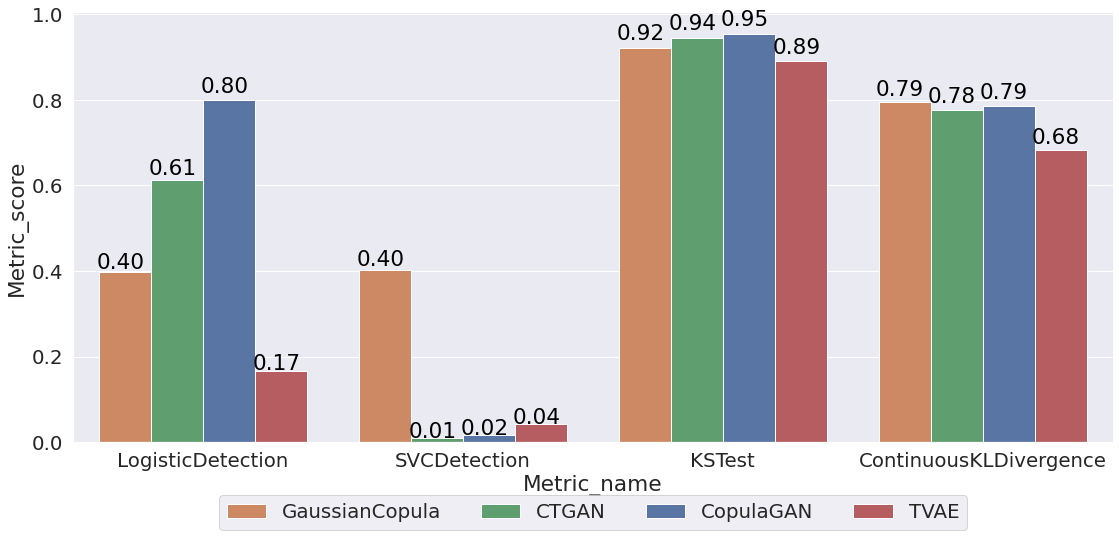

In [159]:
rcParams['figure.figsize'] = (3, 3)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.set(font_scale=1.8) 
plot = sns.catplot(data=gen_result_df_nmf, x="Metric_name", y="Metric_score", hue="Model_name", kind="bar", aspect=2, height=8, palette=[
    "C1", "C2", "C0", "C3", "C4"
], legend=False)
ax = plot.facet_axis(0,0)
hist_val = create_hist_values(gen_result_df_nmf)
for (p, val) in zip(ax.patches, hist_val):
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{:1.2f}'.format(val),   
            color='black', 
            rotation='horizontal', 
            size='medium')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=5)
plt.tight_layout()

# Response function Real component quality

# Logistic Regression

In [100]:
user_features = user_features.withColumnRenamed('id', 'user_idx')

va = VectorAssembler(
    inputCols=user_features.columns[1:] + items_df_train.columns[2:],
    outputCol='features'
)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__lr_prob'
)

train_df = log_df_val.join(user_features, 'user_idx', 'left')\
                     .join(items_df_train, 'item_idx', 'left')\
                     .drop('timestamp')
train_df = train_df.na.drop()

start = time.time()
lr_model = lr.fit(va.transform(train_df))
end = time.time()
print("Fitting of logistic regression: ")
print(end - start)

Fitting of logistic regression: 
53.23414921760559


In [101]:
vee = VectorElementExtractor(inputCol='__lr_prob', outputCol='__r1', index=1)
br = BernoulliResponse (inputCol='__r1', outputCol='response', seed=1234)
pipeline = Pipeline(
    stages=[
        va,
        lr_model,
        vee,
        br
    ]
)

In [107]:
user_features_val = user_features_val.withColumnRenamed('id', 'user_idx')

test_df = log_df_test.join(user_features_val, 'user_idx', 'left')\
                     .join(items_df_val, 'item_idx', 'left')\
                     .drop('timestamp')
test_df = test_df.na.drop()

In [108]:
start = time.time()
ber_lr_model = pipeline.fit(train_df)
end = time.time()
print("Pipeline fitting: ")
print(end - start)
pred_df = ber_lr_model.transform(test_df).select("user_idx", "item_idx", "relevance", "__r1").toPandas()

Pipeline fitting: 
0.0010535717010498047


In [109]:
print(f"Regression ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")

Regression ROC AUC: 0.73624768552898


# Random forest

In [110]:
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__rf_prob'
)

start = time.time()
rf_model = rf.fit(va.transform(train_df))
end = time.time()
print("Fitting of random forest: ")
print(end - start)

Fitting of random forest: 
42.79460883140564


In [111]:
vee = VectorElementExtractor(inputCol='__rf_prob', outputCol='__r1', index=1)
br = BernoulliResponse(inputCol='__r1', outputCol='response', seed=1234)
pipeline = Pipeline(
    stages=[
        va,
        rf_model,
        vee,
        br
    ]
)

In [112]:
start = time.time()
ber_rf_model = pipeline.fit(train_df)
end = time.time()
print("Pipeline fitting: ")
print(end - start)
pred_df = ber_rf_model.transform(test_df).select("user_idx", "item_idx", "relevance", "__r1").toPandas()

Pipeline fitting: 
0.0009860992431640625


In [113]:
print(f"Random forest ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")

Random forest ROC AUC: 0.7095099291681658


# Factorization machines

In [114]:
fm = FMClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__fm_prob'
)

start = time.time()
fm_model = fm.fit(va.transform(train_df))
end = time.time()
print("Fitting of factorization machines: ")
print(end - start)

Fitting of factorization machines: 
1338.5367312431335


In [115]:
vee = VectorElementExtractor(inputCol='__fm_prob', outputCol='__r1', index=1)
br = BernoulliResponse(inputCol='__r1', outputCol='response', seed=1234)
pipeline = Pipeline(
    stages=[
        va,
        fm_model,
        vee,
        br
    ]
)

In [116]:
start = time.time()
ber_fm_model = pipeline.fit(train_df)
end = time.time()
print("Pipeline fitting: ")
print(end - start)
pred_df = ber_fm_model.transform(test_df).select("user_idx", "item_idx", "relevance", "__r1").toPandas()

Pipeline fitting: 
0.0008647441864013672


In [117]:
print(f"Factorization machines ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")

Factorization machines ROC AUC: 0.7156298534061476


In the case of the non-negative least squares method, there is no clearly dominant synthetic generation model in terms of quality. But the quality of the Real component is still higher than in the case of the original profiles for all models of response approximation.

# Autoencoder

In [4]:
LATENT_DIM = 15

encoder = EncoderEstimator(
    inputCols=users_df_train.columns[1:],
    outputCols=[f'emb_{i}' for i in range(LATENT_DIM)],
    hidden_dim=16,
    lr=0.001,
    batch_size=64,
    num_loader_workers=4,
    max_iter=50,
    device_name='cuda'
)

start = time.time()
encoder_model = encoder.fit(users_df_train)
end = time.time()
print("Fitting of aetoencoder: ")
print(end - start)
enc_features = encoder_model.transform(users_df_train)
enc_features.toPandas()

Fitting of aetoencoder: 
174.4888231754303


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14
0,-0.164780,0.077169,-0.179799,0.429831,0.125795,0.207002,0.498695,0.226006,-0.081898,-0.804378,0.653181,0.094246,-0.388401,-0.043588,0.538153
1,-0.291889,0.182307,-0.032616,0.145877,-0.026826,0.151900,0.515950,0.181078,0.040397,-0.757345,0.607979,-0.168300,-0.386507,-0.104466,0.440279
2,-0.349924,0.210760,0.098084,0.161528,-0.090565,0.232034,0.587445,0.104823,0.029568,-0.804924,0.580479,-0.120621,-0.409615,-0.139824,0.443349
3,-0.232771,0.162551,-0.018422,0.088329,-0.032314,0.168563,0.669600,0.073684,-0.160226,-0.693659,0.472148,0.035855,-0.259959,0.089606,0.833725
4,-0.375645,0.195989,0.076924,-0.012892,-0.118391,0.126708,0.756820,0.112910,0.069492,-0.869674,0.548108,0.053427,-0.484422,-0.128403,0.585775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80645,-0.186152,0.123333,-0.103178,0.009931,-0.027160,0.164201,0.565275,0.278902,-0.140223,-0.685138,0.380246,0.212040,-0.223627,0.105385,0.618459
80646,-0.163435,0.142592,-0.073867,0.077939,-0.025052,0.172477,0.598900,0.188655,-0.219803,-0.672039,0.445496,0.142196,-0.224311,0.091841,0.770373
80647,-0.395069,0.135631,-0.023155,-0.098581,-0.146981,0.174019,0.700074,0.274626,0.057349,-0.918438,0.508670,0.128410,-0.499076,-0.031806,0.514576
80648,-0.030144,0.069214,-0.063076,0.339869,0.064605,0.060877,0.744556,0.109563,-0.192898,-0.662415,0.194027,0.592964,-0.267838,0.150874,0.808536


In [5]:
enc_features = enc_features.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
users_df_train = users_df_train.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))

enc_features = enc_features.join(users_df_train, on=["row_index"]).drop("row_index")
cols = (users_df_train.columns[1:])
enc_features = enc_features.drop(*cols)
users_df_train = users_df_train.drop('row_index')

In [121]:
enc_features_val = encoder_model.transform(users_df_val)
enc_features_val = enc_features_val.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
users_df_val = users_df_val.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))

enc_features_val = enc_features_val.join(users_df_val, on=["row_index"]).drop("row_index")
cols = (users_df_val.columns[1:])
enc_features_val = enc_features_val.drop(*cols)

users_df_val = users_df_val.drop('row_index')
enc_features_val.toPandas()

22/10/10 13:03:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 13:03:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,user_idx
0,-0.246064,0.147953,-0.108513,0.237427,0.116161,0.183025,0.642935,0.173701,0.050572,-0.753764,0.613635,0.033574,-0.310413,-0.088402,0.527103,1
1,-0.291889,0.182307,-0.032616,0.145877,-0.026826,0.151900,0.515950,0.181078,0.040397,-0.757345,0.607979,-0.168300,-0.386507,-0.104466,0.440279,2
2,-0.349924,0.210760,0.098084,0.161528,-0.090565,0.232034,0.587445,0.104823,0.029568,-0.804924,0.580479,-0.120621,-0.409615,-0.139824,0.443349,3
3,-0.232771,0.162551,-0.018422,0.088329,-0.032314,0.168563,0.669600,0.073684,-0.160226,-0.693659,0.472148,0.035855,-0.259959,0.089606,0.833725,4
4,-0.375645,0.195989,0.076924,-0.012892,-0.118391,0.126708,0.756820,0.112910,0.069492,-0.869674,0.548108,0.053427,-0.484422,-0.128403,0.585775,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106568,-0.224674,0.083823,-0.103075,0.348862,0.077923,0.201903,0.583711,0.144029,-0.090558,-0.811620,0.605752,0.116336,-0.401801,-0.004696,0.647345,138486
106569,-0.395069,0.135631,-0.023155,-0.098581,-0.146981,0.174019,0.700074,0.274626,0.057349,-0.918438,0.508670,0.128410,-0.499076,-0.031806,0.514576,138487
106570,-0.030144,0.069214,-0.063076,0.339869,0.064605,0.060877,0.744556,0.109563,-0.192898,-0.662415,0.194027,0.592964,-0.267838,0.150874,0.808536,138488
106571,-0.301370,0.144909,-0.044231,-0.229471,-0.060738,0.152091,0.328392,0.261322,-0.006290,-0.721090,0.426295,0.076004,-0.263197,0.043823,0.350579,138490


# GaussianCopula

In [18]:
generator_1 = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='gaussiancopula',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

start = time.time()
generator_1.fit(enc_features.drop('user_idx'))
end = time.time()
print("Fitting of GaussianCopula on autoencoder embeddings: ")
print(end - start)

22/10/08 11:54:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/08 11:54:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Fitting of GaussianCopula on autoencoder embeddings: 
9.619970083236694


In [19]:
real_users = enc_features.sample(0.12)
syn_users = generator_1.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_id'),
    real_users.drop('user_idx')
)

22/10/08 11:54:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/08 11:54:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/08 11:54:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/08 11:54:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [38]:
gen_score

{'LogisticDetection': 1.0,
 'SVCDetection': 0.29530958576768185,
 'KSTest': 0.9718063508589277,
 'ContinuousKLDivergence': 0.9619241035364077}

In [39]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'GaussianCopula'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_enc = pd.DataFrame()
gen_result_df_enc = pd.concat([gen_result_df_enc, gen_result])
gen_result_df_enc

,Model_name,Metric_score,Metric_name
0,GaussianCopula,1.000000,LogisticDetection
1,GaussianCopula,0.295310,SVCDetection
2,GaussianCopula,0.971806,KSTest
3,GaussianCopula,0.961924,ContinuousKLDivergence


# CTGAN

In [12]:
generator_2 = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='ctgan',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

start = time.time()
generator_2.fit(enc_features.sample(0.12).drop('user_idx'))
end = time.time()
print("Fitting of CTGAN on autoencoder embeddings: ")
print(end - start)

22/10/08 09:52:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/08 09:52:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Fitting of CTGAN on autoencoder embeddings: 
6960.759202718735


In [14]:
real_users = enc_features.sample(0.12)
syn_users = generator_2.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_id'),
    real_users.drop('user_idx')
)

22/10/08 11:49:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/08 11:49:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/08 11:49:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/08 11:49:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [15]:
gen_score

{'LogisticDetection': 0.6603109516188939,
 'SVCDetection': 0.003336165530971935,
 'KSTest': 0.9222405839013976,
 'ContinuousKLDivergence': 0.8915377524894995}

In [41]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'CTGAN'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_enc = pd.concat([gen_result_df_enc, gen_result])
gen_result_df_enc

,Model_name,Metric_score,Metric_name
0,GaussianCopula,1.000000,LogisticDetection
1,GaussianCopula,0.295310,SVCDetection
2,GaussianCopula,0.971806,KSTest
3,GaussianCopula,0.961924,ContinuousKLDivergence
0,CTGAN,0.660311,LogisticDetection
1,CTGAN,0.003336,SVCDetection
2,CTGAN,0.922241,KSTest
3,CTGAN,0.891538,ContinuousKLDivergence


# CopulaGAN

In [22]:
generator_3 = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='copulagan',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

start = time.time()
generator_3.fit(enc_features.sample(0.12).drop('user_idx'))
end = time.time()
print("Fitting of CopulaGAN on autoencoder embeddings: ")
print(end - start)

22/10/08 11:58:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/08 11:58:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Fitting of CopulaGAN on autoencoder embeddings: 
7253.474634885788


In [23]:
real_users = enc_features.sample(0.12)
syn_users = generator_3.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_id'),
    real_users.drop('user_idx')
)

22/10/08 18:38:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/08 18:38:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/08 18:38:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/08 18:38:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [24]:
gen_score

{'LogisticDetection': 0.6665707938587018,
 'SVCDetection': 0.0023839083134173933,
 'KSTest': 0.9051830718021875,
 'ContinuousKLDivergence': 0.8653988335761549}

In [43]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'CopulaGAN'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_enc = pd.concat([gen_result_df_enc, gen_result])
gen_result_df_enc

,Model_name,Metric_score,Metric_name
0,GaussianCopula,1.000000,LogisticDetection
1,GaussianCopula,0.295310,SVCDetection
2,GaussianCopula,0.971806,KSTest
3,GaussianCopula,0.961924,ContinuousKLDivergence
0,CTGAN,0.660311,LogisticDetection
1,CTGAN,0.003336,SVCDetection
2,CTGAN,0.922241,KSTest
3,CTGAN,0.891538,ContinuousKLDivergence
0,CopulaGAN,0.666571,LogisticDetection
1,CopulaGAN,0.002384,SVCDetection


# TVAE

In [29]:
generator_4 = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='tvae',
    parallelization_level=4,
    seed=1234
)

start = time.time()
generator_4.fit(enc_features.drop('user_idx'))
end = time.time()
print("Fitting of TVAE on autoencoder embeddings: ")
print(end - start)

22/10/08 19:07:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/08 19:07:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Fitting of TVAE on autoencoder embeddings: 
5441.039732217789


In [30]:
real_users = enc_features.sample(0.12)
syn_users = generator_4.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_id'),
    real_users.drop('user_idx')
)

22/10/08 20:38:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/08 20:38:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/08 20:38:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/08 20:38:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [31]:
gen_score

{'LogisticDetection': 0.6060665911133962,
 'SVCDetection': 0.10587860432890006,
 'KSTest': 0.9188982297860705,
 'ContinuousKLDivergence': 0.8967639818738263}

In [45]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'TVAE'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_enc = pd.concat([gen_result_df_enc, gen_result])
gen_result_df_enc

,Model_name,Metric_score,Metric_name
0,GaussianCopula,1.000000,LogisticDetection
1,GaussianCopula,0.295310,SVCDetection
2,GaussianCopula,0.971806,KSTest
3,GaussianCopula,0.961924,ContinuousKLDivergence
0,CTGAN,0.660311,LogisticDetection
1,CTGAN,0.003336,SVCDetection
2,CTGAN,0.922241,KSTest
3,CTGAN,0.891538,ContinuousKLDivergence
0,CopulaGAN,0.666571,LogisticDetection
1,CopulaGAN,0.002384,SVCDetection


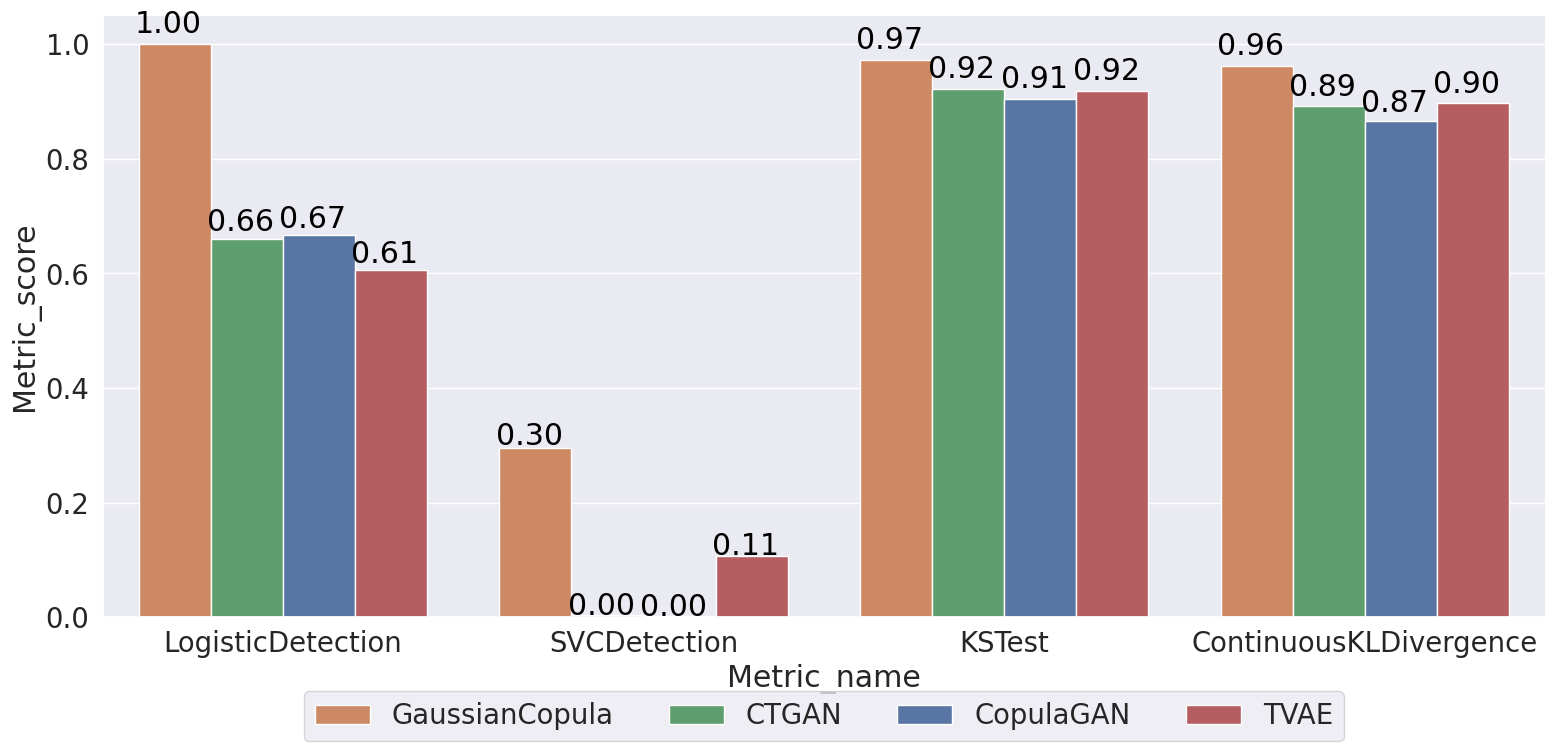

In [46]:
rcParams['figure.figsize'] = (3, 3)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.set(font_scale=1.8) 
plot = sns.catplot(data=gen_result_df_enc, x="Metric_name", y="Metric_score", hue="Model_name", kind="bar", aspect=2, height=8, palette=[
    "C1", "C2", "C0", "C3", "C4"
], legend=False)
ax = plot.facet_axis(0,0)
hist_val = create_hist_values(gen_result_df_enc)
for (p, val) in zip(ax.patches, hist_val):
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{:1.2f}'.format(val),   
            color='black', 
            rotation='horizontal', 
            size='medium')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=5)
plt.tight_layout()

# Response function Real component quality

# Logistic Regression

In [119]:
va = VectorAssembler(
    inputCols=enc_features.columns[:-1] + items_df_train.columns[2:],
    outputCol='features'
)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__lr_prob'
)

train_df = log_df_val.join(enc_features, 'user_idx', 'left')\
                     .join(items_df_train, 'item_idx', 'left')\
                     .drop('timestamp')
train_df = train_df.na.drop()

start = time.time()
lr_model = lr.fit(va.transform(train_df))
end = time.time()
print("Fitting of logistic regression: ")
print(end - start)

22/10/10 12:50:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 12:50:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 12:50:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 12:50:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 12:51:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 12:51:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 1

Fitting of logistic regression: 
42.29240918159485


22/10/10 12:51:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 12:51:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [120]:
vee = VectorElementExtractor(inputCol='__lr_prob', outputCol='__r1', index=1)
br = BernoulliResponse (inputCol='__r1', outputCol='response', seed=1234)
pipeline = Pipeline(
    stages=[
        va,
        lr_model,
        vee,
        br
    ]
)

In [123]:
test_df = log_df_test.join(enc_features_val, 'user_idx', 'left')\
                     .join(items_df_val, 'item_idx', 'left')\
                     .drop('timestamp')
test_df = test_df.na.drop()

In [124]:
start = time.time()
ber_lr_model = pipeline.fit(train_df)
end = time.time()
print("Pipeline fitting: ")
print(end - start)
pred_df = ber_lr_model.transform(test_df).select("user_idx", "item_idx", "relevance", "__r1").toPandas()

Pipeline fitting: 
0.0008294582366943359


22/10/10 13:04:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 13:04:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [125]:
print(f"Regression ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")

Regression ROC AUC: 0.7328205862135375


# Random forest

In [126]:
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__rf_prob'
)

start = time.time()
rf_model = rf.fit(va.transform(train_df))
end = time.time()
print("Fitting of random forest: ")
print(end - start)

22/10/10 13:05:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 13:05:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 13:05:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 13:05:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 13:06:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 13:06:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 1

Fitting of random forest: 
47.818604469299316


22/10/10 13:06:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 13:06:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [127]:
vee = VectorElementExtractor(inputCol='__rf_prob', outputCol='__r1', index=1)
br = BernoulliResponse(inputCol='__r1', outputCol='response', seed=1234)
pipeline = Pipeline(
    stages=[
        va,
        rf_model,
        vee,
        br
    ]
)

In [128]:
start = time.time()
ber_rf_model = pipeline.fit(train_df)
end = time.time()
print("Pipeline fitting: ")
print(end - start)
pred_df = ber_rf_model.transform(test_df).select("user_idx", "item_idx", "relevance", "__r1").toPandas()

Pipeline fitting: 
0.0004703998565673828


22/10/10 13:06:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 13:06:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [129]:
print(f"Random forest ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")

Random forest ROC AUC: 0.7102963776389692


# Factorization machines

In [130]:
fm = FMClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__fm_prob'
)

start = time.time()
fm_model = fm.fit(va.transform(train_df))
end = time.time()
print("Fitting of factorization machines: ")
print(end - start)

22/10/10 13:08:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 13:08:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 13:08:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 13:08:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 13:28:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 13:28:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Fitting of factorization machines: 
1235.5770754814148


22/10/10 13:28:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 13:28:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [131]:
vee = VectorElementExtractor(inputCol='__fm_prob', outputCol='__r1', index=1)
br = BernoulliResponse(inputCol='__r1', outputCol='response', seed=1234)
pipeline = Pipeline(
    stages=[
        va,
        fm_model,
        vee,
        br
    ]
)

In [132]:
start = time.time()
ber_fm_model = pipeline.fit(train_df)
end = time.time()
print("Pipeline fitting: ")
print(end - start)
pred_df = ber_fm_model.transform(test_df).select("user_idx", "item_idx", "relevance", "__r1").toPandas()

Pipeline fitting: 
0.0013365745544433594


22/10/10 13:29:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/10 13:29:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [133]:
print(f"Factorization machines ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")

Factorization machines ROC AUC: 0.6727904587541585


The quality of synthetic generation models in the case of autoencoder based embeddings is slightly worse than in the case of PCA. The quality of Real component on embeddings exceeds the quality of Real component on original profiles for all response models except Factorisation machines.

According to the results of the experimental study it was decided to use the PCA method to generate embeddings of user profiles in the case of MovieLens dataset.